# Static compression on random quads design 8x8: experiment vs simulation

## Imports

In [21]:
import numpy as np
from problems.hinge_characterization import ForwardProblemQuads
from pathlib import Path
from typing import List
from difflexmm.plotting import generate_animation

from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)
from jax import random

import matplotlib.pyplot as plt
plt.style.use(["science", "grid"])
%matplotlib widget


## Helper functions

In [15]:
def read_instron_data(path: str):
    time, displacement, force = np.loadtxt(
        path, skiprows=3, delimiter=",", unpack=True)
    return time, displacement, force


def compute_mean_std(data: dict):
    return {test: np.array([test_data[0, 0, :], test_data[:, 1, :].mean(axis=0), test_data[:, 1, :].std(axis=0)]) for test, test_data in data.items()}


def plot_raw_force_displacement_curves(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(7, 4))

    for file in paths:
        _, u, f = read_instron_data(file)
        axes.plot(u, f, **plot_kwargs)

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    fig.tight_layout()

    return fig, axes


def resample(t, f, n_points):
    return np.interp(np.linspace(np.min(t), np.max(t), n_points), t, f)


def plot_force_displacement_stats(paths: List[str], **plot_kwargs):
    fig, axes = plt.subplots(figsize=(12, 5), constrained_layout=True)

    u_list = []
    f_list = []
    for file in paths:
        t, u, f = read_instron_data(file)
        u = resample(t, u, 200)
        f = resample(t, f, 200)
        u_list.append(u)
        f_list.append(f)
    u_list = np.array(u_list)
    f_list = np.array(f_list)
    # Compute mean and std of force
    f_mean = np.mean(f_list, axis=0)
    f_std = np.std(f_list, axis=0)
    axes.plot(u_list[0], f_mean, **plot_kwargs)
    axes.fill_between(u_list[0], f_mean - f_std,
                      f_mean + f_std, alpha=0.5, **plot_kwargs)

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")
    return fig, axes

## Paths

In [4]:
# Where to load/save the experimental/optimization data
data_folder = Path("../../data/hinge_characterization_3dp_pla_shims")
# Where to save the plots
out_folder = Path("../../out/hinge_characterization_3dp_pla_shims")

## Simulate the experiment

In [7]:
n1_blocks = 8
n2_blocks = 10  # Top and bottom rows are clamped
spacing = 15.0  # mm
hinge_length = 0.15*spacing
horizontal_shifts = 0.2*spacing * \
    random.uniform(random.PRNGKey(0), (n1_blocks+1,
                   n2_blocks, 2), minval=-1., maxval=1.)
vertical_shifts = 0.2*spacing * \
    random.uniform(random.PRNGKey(
        0), (n1_blocks, n2_blocks+1, 2), minval=-1., maxval=1.)

k_stretch = 120.  # N/mm
k_shear = 1.19  # N/mm
k_rot = 1.5  # N/mm
density = 1.0  # Fake inertia for quasi-static analysis
damping = 0.015

test_label = "compression"
amplitude = 4.5  # mm
force_multiplier = -1.
problem = ForwardProblemQuads(
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    horizontal_shifts=horizontal_shifts,
    vertical_shifts=vertical_shifts,
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    loading_type=test_label,
    amplitude=amplitude,  # mm
    force_multiplier=force_multiplier,
    loading_rate=0.01 * ((k_rot/(density*spacing**4))**0.5),
    n_timepoints=200,
    use_contact=False,
    name=f"hinge_characterization_3dp_pla_shims_"
)

# Simulate the response
problem.setup()
simulated_response = problem.force_displacement(
    *problem.solve((k_stretch, k_shear, k_rot))
)

### Plot force-displacement: experiment vs simulation

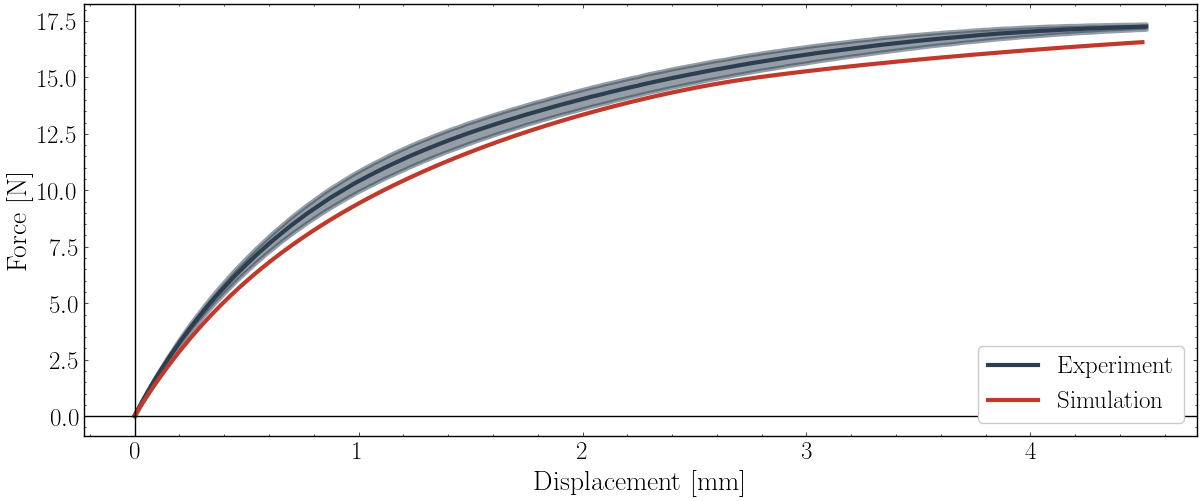

In [20]:
# Import the experimental data
data_files = sorted(
    list(Path(f"{data_folder}/instron-data/compression_10.0_quad_random_spacing_15.0_hinge_2.2_mm.is_ccyclic_Exports/").glob("*.txt"))
)[1:]  # Drop first run as it is not representative

fig, axes = plot_force_displacement_stats(
    data_files, lw=3, label="Experiment", color="#2c3e50")
axes.plot(simulated_response[0], simulated_response[1],
          lw=3, label="Simulation", color="#c0392b")
axes.set_xlabel("Displacement [mm]", fontsize=20)
axes.set_ylabel("Force [N]", fontsize=20)
axes.tick_params(axis="both", labelsize=18)
axes.grid(False)
axes.axhline(0, color="black", lw=1)
axes.axvline(0, color="black", lw=1)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
handles, labels = axes.get_legend_handles_labels()
axes.legend([handles[0], handles[-1]], [labels[0], labels[-1]], fontsize=18, loc="lower right")
fig.savefig(out_folder / "validation_compression_8x8_quad_random_spacing_15.0_hinge_2.25.png", dpi=300)

### Animation

In [ ]:
xlim, ylim = problem.geometry.get_xy_limits(problem.horizontal_shifts, problem.vertical_shifts
) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

generate_animation(
    data=problem.solve((problem.k_stretch, problem.k_shear, problem.k_rot))[0],
    field="u",
    out_filename=f"{out_folder}/validation_compression_8x8_quad_random_spacing_15.0_hinge_2.25",
    deformed=True,
    xlim=xlim,
    ylim=ylim,
    dpi=300,
    fps=30,
    figsize=(6, 7),
    cmap="inferno",
    legend_label="Displacement [mm]",
)
